In [ ]:
!pip install wandb
!pip install einops
!pip install matplotlib
!pip install lion-pytorch
!wandb login ...

In [1]:
import os, random, torch, wandb
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast
from einops import rearrange
# from torch.optim import Adam
from lion_pytorch import Lion
from torch import einsum
from math import sqrt
from time import time

### define GELU activation, LayerNorm module, GPT Layer, and GPT

In [2]:
# GELU(x) = x * ϕ(x) where ϕ is the CDF of the Gaussian distribution
class GELU(nn.Module):
  def forward(self, x):
    return x * 0.5 * (1 + torch.erf(x / sqrt(2)))

In [3]:
class LayerNorm(nn.Module):
  def __init__(self, d, eps=1e-5):
    super().__init__()
    self.d, self.eps = d, eps
    self.w = nn.Parameter(torch.tensor(1.))
    self.b = nn.Parameter(torch.tensor(0.))

  def forward(self, x):
    for i in range(len(x.shape) - 1, -1, -1):
      if x.shape[i] == self.d:
        d = i
        break
    mu = x.mean(d).unsqueeze(d)  # E[x]
    mu_ = (x * x).mean(d).unsqueeze(d)  # E[x^2]
    sigma = torch.sqrt(mu_ - mu * mu + self.eps)
    return self.w * (x - mu) / sigma + self.b

In [4]:
class Layer(nn.Module):
  def __init__(self, d, nh):
    super().__init__()
    assert d % nh == 0, 'number of heads should divide embedding dim'
    self.d, self.nh, self.h = d, nh, d // nh
    self.wx, self.wo = nn.Linear(d, 3 * d), nn.Linear(d, d)
    self.ln1, self.ln2 = LayerNorm(d), LayerNorm(d)
    self.ffn = nn.Sequential(
      nn.Linear(d, 4 * d), GELU(), nn.Linear(4 * d, d)
    )

    def fn(m):
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.02)
        nn.init.zeros_(m.bias)

    self.apply(fn)

  def forward(self, xm):
    x, m = xm
    qkv = rearrange(self.wx(self.ln1(x)), 'b l D -> b D l')
    q, k, v = rearrange(qkv, 'b (N h) l -> b N h l', h=self.h).split(self.nh, 1)
    A = F.softmax((einsum('bhri, bhrj -> bhij', q, k) + m) / sqrt(self.d), -1)
    H = einsum('bhic, bhjc -> bhij', v, A)
    MHA = rearrange(rearrange(H, 'b nh h l -> b (nh h) l'), 'b d l -> b l d')
    x = x + self.wo(MHA)
    return x + self.ffn(self.ln2(x)), m

In [5]:
class GPT(nn.Module):
  def __init__(self, d, nh, nl, l, v):
    super().__init__()
    self.l = l
    self.emb = nn.Embedding(v, d)  # token embeddings 
    nn.init.normal_(self.emb.weight, 0, 0.02)
    self.pos = nn.Parameter(torch.randn(l, d) * 0.02)  # learned position embeddings
    m = torch.tril(torch.ones(l, l)) - 1
    m[m == -1] = float('-inf')
    self.m = nn.Parameter(m, requires_grad=False)  # mask
    self.layers = nn.Sequential(*[Layer(d, nh) for _ in range(nl)])  # layers 
    self.out = nn.Linear(d, v, bias=False)  # embedding to logits projection 
    nn.init.normal_(self.out.weight, 0, 0.02)
    self.size = sum(p.numel() for p in self.parameters() if p.requires_grad)

  def forward(self, t):
    l = t.shape[-1]
    assert l <= self.l, f'input sequence length should be <= {self.l}'
    if len(t.shape) == 1:
      t = t.unsqueeze(0)  # (l,) to (1, l)
    xm = (self.emb(t) + self.pos[:l], self.m[:l, :l])
    return self.out(self.layers(xm)[0]).squeeze()

  def loss(self, it, ot):
    return F.cross_entropy(
      rearrange(self(it), 'b l v -> (b l) v'), rearrange(ot, 'b l -> (b l)')
    )

### load dataset, create encoder and decoder

In [6]:
text = open('HP.txt', 'r').read()
print(f'size of the text: {len(text)} characters')

size of the text: 6765174 characters


In [7]:
vocab = sorted(list(set(text)))
print(f'size of the vocabulary: {len(vocab)} characters')
print(''.join(vocab))

size of the vocabulary: 92 characters

 !"%&'()*,-./0123456789:;>?ABCDEFGHIJKLMNOPQRSTUVWXYZ\]abcdefghijklmnopqrstuvwxyz|~—‘’“”•■□


In [8]:
stoi = {s: i for i, s in enumerate(vocab)}
itos = {i: s for i, s in enumerate(vocab)}
encode = lambda string: [stoi[x] for x in string]
decode = lambda ids: ''.join([itos[x] for x in ids])

# test
print(decode(encode('Hello, World!')))
print(encode(decode([1, 2, 3, 4, 5])))

Hello, World!
[1, 2, 3, 4, 5]


In [9]:
train_ids = encode(text)
# character-level encoding => this equality should hold
assert len(train_ids) == len(text)
# convert to tensor
train_ids = torch.tensor(train_ids)

In [10]:
def get_batch(batch_size, l, device):
  ids = random.choices(range(len(train_ids) - l - 1), k=batch_size) 
  batch = torch.stack([train_ids[i:i + l + 1] for i in ids])
  return batch[:, :-1].to(device), batch[:, 1:].to(device)

In [11]:
d = 12 * 30
nh = 12
nl = 8
l = 256
v = len(vocab)
batch_size = 64
steps = 15000
interval = 100
lr = 2e-4 / 3  # paper recommends 3x smaller lr than Adam

if torch.cuda.is_available():
  device = 'cuda'
elif torch.backends.mps.is_available():
  device = 'mps'
else:
  device = 'cpu'

In [12]:
model = GPT(d, nh, nl, l, v).to(device)
print(f'size of the model: {model.size} parameters')
optimizer = Lion(model.parameters(), lr=lr)

size of the model: 12625952 parameters


### train loop

In [13]:
wandb.init(project='Harry Potter GPT')
wandb.run.name = 'Lion lr/3'

losses = []
scaler = GradScaler()
s = time()
for i in range(1, steps + 1):
  # fp16 training
  with autocast():
    loss = model.loss(*get_batch(batch_size, l, device))
  # logging
  losses.append(loss.item())
  wandb.log({'loss': losses[-1]})
  if i % interval == 0:
    avg_loss = sum(losses[-interval:]) / interval 
    print(f'loss: {avg_loss}\tstep: {i}\ttime: {time() - s}s')
    s = time()
  # training step
  scaler.scale(loss).backward()
  scaler.step(optimizer)
  scaler.update()
  optimizer.zero_grad()

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: akbirthko. Use `wandb login --relogin` to force relogin


loss: 2.7968092155456543	step: 100	time: 9.565938711166382s
loss: 2.4374247646331786	step: 200	time: 9.08692479133606s
loss: 2.345831377506256	step: 300	time: 9.05469560623169s
loss: 2.2415652966499326	step: 400	time: 9.046038389205933s
loss: 2.119318890571594	step: 500	time: 9.093839883804321s
loss: 1.991312314271927	step: 600	time: 9.046479225158691s
loss: 1.8567785894870759	step: 700	time: 9.065043449401855s
loss: 1.7315952229499816	step: 800	time: 9.053457498550415s
loss: 1.6134381330013274	step: 900	time: 9.050904750823975s
loss: 1.5247160840034484	step: 1000	time: 9.062872171401978s
loss: 1.4439779508113861	step: 1100	time: 9.09062671661377s
loss: 1.3710617697238923	step: 1200	time: 8.961026668548584s
loss: 1.3143145155906677	step: 1300	time: 9.011752605438232s
loss: 1.263537164926529	step: 1400	time: 9.05294156074524s
loss: 1.2250139784812928	step: 1500	time: 9.03203797340393s
loss: 1.189524837732315	step: 1600	time: 9.05607533454895s
loss: 1.1569825088977814	step: 1700	time: 9.

loss,█▇▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.49805


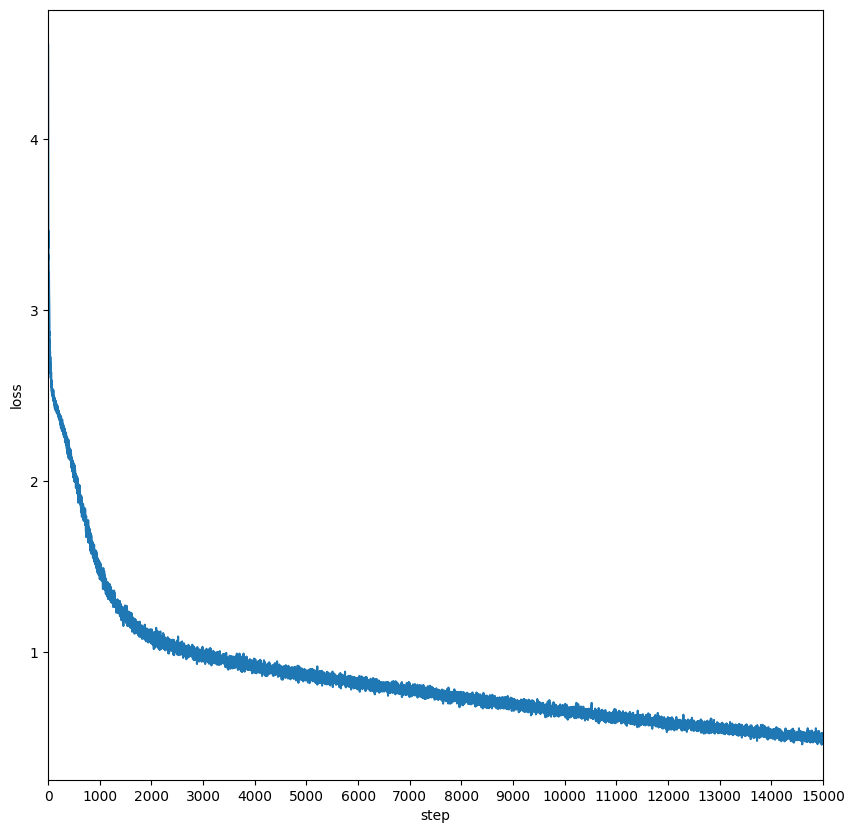

In [14]:
fig = plt.figure(figsize=(10, 10))
plt.xlabel('step')
plt.ylabel('loss')
plt.xlim(0, steps)
plt.xticks(list(range(0, steps + 1000, 1000)))
plt.plot(list(range(steps)), losses)

### test the model

In [15]:
def generate(model, text, n, temp=0.9, device='cpu'):
  assert len(text) > 0
  print(text, end='')
  it = torch.tensor(encode(text)).to(device)  # input tokens
  with torch.no_grad():
    for _ in range(n):
      p = F.softmax(model(it[-model.l:]) / temp, -1)[-1]  # prob distribution
      t = torch.multinomial(p, 1)  # next token
      it = torch.cat((it, t), -1)  # concatenate with prev tokens
      text += decode([t.item()])  # concatenate with prompt
      print(text[-1], end='')
    return text, it  # return completed text and tokens

In [16]:
_ = generate(model, 'Harry and Hagrid entered Diagon Alley', 500, device=device)

Harry and Hagrid entered Diagon Alley. “What in the 
library who can particular doze, if you can clear 
then, McGonagall, you’re in shocolor by our maniful 
school ...” 

“I’m getting better,” said Hagrid carelessly, standing up 
and strode backward. 

“I’m not young, you’re not Mought — Miss Batile’s — ” 

“ — am I speaking to my bersee that you are the 
exilarraration for me at hearing about my races.” 

“Has Secrets returned to the castle for years, and 
will September the orchestration I suffered down 
matters in concentration,

In [17]:
_ = generate(model, 'Voldemort cast his wand aside and', 500, device=device)

Voldemort cast his wand aside and he looked at 
Voldemort. 



Page | 430 Harry Potter and the Prisoner of Azkaban - J.K. Rowling 




“Good evening, Harry!” roared Snape. 

“Everybody left Hogsmeade you conjured,” said 
Dumbledore, talking over him and his face pressed 
again the door so closed. “Excellent, are you all right?” 

Page | 608 Harry Potter and the Half Blood Prince - J.K. Rowling 




“No, no,” said Voldemort softly, “that’s really much 
more than that. We’ve trafficks first. Dumbledore 
only hasn’t backed, but I 

In [18]:
_ = generate(
  model,
  'Dumbledore sent a blast of fire from his wand direct at Voldemort',
  2000,
  temp=0.3,
  device=device
)

Dumbledore sent a blast of fire from his wand direct at Voldemort, 
and the snake beyond the greenhouses had been 
struggled to a halt in the darkness. 

“It’s a good one,” said Harry casually. 

“Yes, it is!” said Dumbledore, and he took the 
maze. 

“This beautiful wizard is empty. Do you wish me to 
see me, Harry?” 

“Sorry, but — but I didn’t think you wanted to 
use them all sing: the teachers dog, and the ones who 
had been waiting for them all summer. They were 
starting to get dirmirors, though their figures making 
powers above them windows. 

“What’s the — ?” 

“Summons,” said Harry, “you’ve met her, as a matter of 
fact.” 

“You’re a natural illness,” said Madam Pomfrey, beaming 
at him. 

“You’re not allowed to come here?” said Moody. 

His hand closed in midair, his eyes widening slightly. 
The orcasional sounded over the vastness of the 
wind and had set for him giving Harry a heat, 

“I’ve got to go first, I’ve got to a leaf of our books.” 

“What happened to you?” Ron a

### save the model checkpoint

In [19]:
torch.save(model.state_dict(), 'GPT-HP-Lion-2.pt')